In [257]:
from os.path import isfile, join
from os import listdir
import json
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

In [258]:
#Takes a trace of type: [{"data": {'xGyro':324, ...}, "time": 234324.3434}, ...] and turns it into
# [{"times" : [2343.23423, 234234.23423, ....], "xGyros": [234, 234, 2343, 453, ...], "yGyros": [345,345,...], ...}]
def traceFormatter(trace):
    
    xGyros = []
    zAccls = []
    yGyros = []
    zGyros = []
    xAccls = []
    xMags = []
    yMags = []
    zMags = []
    yAccls = []
    times = []
    
    
    for sample in trace:
        data = sample['data']
        time = sample['time']

        xGyros.append(data['xGyro'])
        yGyros.append(data['yGyro'])
        zGyros.append(data['zGyro'])
        xAccls.append(data['xAccl'])
        yAccls.append(data['yAccl'])
        zAccls.append(data['zAccl'])
        xMags.append(data['xMag'])
        yMags.append(data['yMag'])
        zMags.append(data['zMag'])
        times.append(time)
    
    #Normalize times
    firstTime = times[0]
    for i in range(len(times)):
        times[i] = times[i] - firstTime
        
    new = {}
    
    new['times'] = times
    new['xGyros'] = xGyros
    new['yGyros'] = yGyros
    new['zGyros'] = zGyros
    new['xAccls'] = xAccls
    new['yAccls'] = yAccls
    new['zAccls'] = zAccls
    new['xMags'] = xMags
    new['yMags'] = yMags
    new['zMags'] = zMags
    
    
    return(new)




#Takes the jason file of [{"type": "Driving", "seq": [{"data": {xGyro : 54, ...}, "time" : 234.234234}, ...]}, ...]
#Turns it into, e.x. traceDict["Driving"] = list of traces [{"times" : [0, 0.23423, ....], "xGyros": [234, 234, 2343, 453, ...], "yGyros": [345,345,...], ...}]
def makeTraceDict(PATH):
    onlyfiles = [f for f in listdir(PATH) if isfile(join(PATH, f))]

    jsonLists = []

    for file in onlyfiles:
        with open(join(PATH, file)) as fp:
            temp = json.load(fp)
            jsonLists.append(temp)

    drivingTraces = []
    walkingTraces = []
    jumpingTraces = []
    standingTraces = []
    
    if isinstance(jsonLists[0], (list,)):
        for ls in jsonLists:
            for dict in ls:
                action = dict['type']


                if 'Jumping' in action:
                    jumpingTraces.append(traceFormatter(dict['seq']))
                elif 'Driving' in action:
                    drivingTraces.append(traceFormatter(dict['seq']))
                elif 'Standing' in action:
                    standingTraces.append(traceFormatter(dict['seq']))
                elif 'Walking' in action:
                    walkingTraces.append(traceFormatter(dict['seq']))
                else:
                    print("LOOKY HERE ^^^^")
                    print(repr(action))
                    exit(1)
    else:
        for dict in jsonLists:
            action = dict['type']


            if 'Jumping' in action:
                jumpingTraces.append(traceFormatter(dict['seq']))
            elif 'Driving' in action:
                drivingTraces.append(traceFormatter(dict['seq']))
            elif 'Standing' in action:
                standingTraces.append(traceFormatter(dict['seq']))
            elif 'Walking' in action:
                walkingTraces.append(traceFormatter(dict['seq']))
            else:
                print("LOOKY HERE ^^^^")
                print(repr(action))
                exit(1)

    
    traceDict = {"Driving":drivingTraces, "Standing":standingTraces, "Walking":walkingTraces, "Jumping":jumpingTraces}
                
    return(traceDict)



In [259]:
PATH = 'data/'


traceDict = makeTraceDict(PATH)

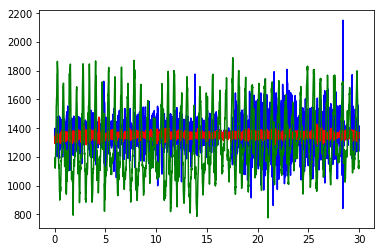

In [260]:
dTimes = traceDict["Driving"][0]["times"]
dzAccls = traceDict["Driving"][0]["zAccls"]

sTimes = traceDict["Standing"][0]["times"]
szAccls = traceDict["Standing"][0]["zAccls"]

wTimes = traceDict["Walking"][0]["times"]
wzAccls = traceDict["Walking"][0]["zAccls"]

#jTimes = traceDict["Jumping"][0]["times"]
#jzAccls = traceDict["Jumping"][0]["zAccls"]



#plt.plot(dTimes, dzAccls, 'b', sTimes, szAccls, 'r', wTimes, wzAccls, 'g', jTimes, jzAccls, 'y')
plt.plot(dTimes, dzAccls, 'b', sTimes, szAccls, 'r', wTimes, wzAccls, 'g')

In [261]:
#Calculate/Collect stats about a trace
def traceStatMaker(trace):
        
        keys = trace.keys()
        
        statTrace = {}
        
       
        for key in keys:
            #Do not want stats on time
            if key == 'times':
                continue
            data = trace[key]
            
            
            mean = np.mean(data)
            stdDev = np.std(data)
            roughFreq = freq(key, data, trace['times']) #rough approximation
            
            statTrace[key] = {'mean':mean, 'std':stdDev, 'freq':roughFreq}
            
        return(statTrace)

#Determine rough frequency of signal: [123, 123, 324, 3453, 6456, ...] by counting how frequently it crosses the mean line
def freq(key, data, times):
    mean = np.mean(data)
    
    if data[0] - mean == 0:
        if data[1] - data[0] > 0:
            above = True
            below = False
        else:
            above = False
            below = True
    elif data[0] - mean > 0:
        above = True
        below = False
    else:
        above = False
        below = True
        
    crossingTimes = []
    for i, datum in enumerate(data):
        
        #Crossed from below to above mean
        if below and (datum - mean > 0):
            above = True
            below = False
            crossingTimes.append(times[i])
        
        #Crossed from above to below mean
        if above and (datum - mean < 0):
            above = False
            below = True
            crossingTimes.append(times[i])
    
    if len(crossingTimes) == 0:
        print("Recorded no crossings. We have a problem.")
        exit(1)
    
    tDiffs = []
    i = 0
    for i in range(len(crossingTimes)):
        #Skip first time
        if not(i):
            continue

        tDiffs.append(crossingTimes[i] - crossingTimes[i-1])

    
    if len(tDiffs) == 0:
        avgFreq = 0
    else:
        avgFreq = np.mean(tDiffs)
    
    
    return(avgFreq)
        
    

In [262]:
traceStatMaker(traceDict["Walking"][0])
#print(traceStatMaker(traceDict["Jumping"][0])['zAccls'])

{'xGyros': {'mean': -52.99181446111869,
  'std': 229.35850617142577,
  'freq': 0.1324050181678363},
 'yGyros': {'mean': 30.819099590723056,
  'std': 310.08953997237745,
  'freq': 0.22483006635106595},
 'zGyros': {'mean': -124.37762619372442,
  'std': 629.7813352662604,
  'freq': 0.3913426977215391},
 'xAccls': {'mean': -6.266302864938608,
  'std': 95.48252425891906,
  'freq': 0.1823171954944821},
 'yAccls': {'mean': 392.92360163710777,
  'std': 211.91715453049028,
  'freq': 0.243374520201024},
 'zAccls': {'mean': 1300.355252387449,
  'std': 236.08275739391743,
  'freq': 0.20550126207285913},
 'xMags': {'mean': -695.2616643929059,
  'std': 330.0828876282532,
  'freq': 2.163108845551809},
 'yMags': {'mean': 191.7800818553888,
  'std': 346.91969212194505,
  'freq': 2.657660881678263},
 'zMags': {'mean': 232.04774897680764,
  'std': 105.80282137363749,
  'freq': 0.5812001419067383}}

In [263]:
#Calculate/Collect stats about the population of traces within a type
# Returns something of the type {'sensor': {'stat': {'mean': xxx, 'std': xxx}, ...}, ...}
#Where the stat's "mean" and "std" are the mean and std of that statistic across all traces of the activity type.
#So, note, you can have the mean and std OF the mean and/or std OF a particular sensor.
def popStatMaker(traces):
    
    popStatDict = {}
    
    #List comprehension for removing the "s" at the end of these keys
    sensorKeys = [s[:-1] for s in traceStatMaker(traces[0]).keys()]
    statKeys = traceStatMaker(traces[0])[sensorKeys[0]+'s'].keys()
    
    
    #Initialize the popStatDict
    for sensorKey in sensorKeys:
        popStatDict[sensorKey] = {}
        for statKey in statKeys:
            popStatDict[sensorKey][statKey] = []

            
    for trace in traces:
        traceStatDict = traceStatMaker(trace)
        for sensorKey in sensorKeys:
            for statKey in statKeys:
                popStatDict[sensorKey][statKey].append(traceStatDict[sensorKey+'s'][statKey])
                

    for sensorKey in sensorKeys:
        for statKey in statKeys:
            data = popStatDict[sensorKey][statKey]
              
            mean = np.mean(data)
            std = np.std(data)
            
            popStatDict[sensorKey][statKey] = {'mean':mean, 'std':std}
    
    return(popStatDict)

  

In [264]:
popStatMaker(traceDict["Walking"])

{'xGyro': {'mean': {'mean': -17.436637988245995, 'std': 48.89783263830316},
  'std': {'mean': 187.5952515823108, 'std': 79.3017114109516},
  'freq': {'mean': 0.12211651020513185, 'std': 0.020249177013898022}},
 'yGyro': {'mean': {'mean': 40.8707943149244, 'std': 21.39374512192982},
  'std': {'mean': 227.38870414157282, 'std': 66.02685794755293},
  'freq': {'mean': 0.15888554669137248, 'std': 0.02982674702642113}},
 'zGyro': {'mean': {'mean': -12.03326695652564, 'std': 288.1137593059323},
  'std': {'mean': 449.7640745663783, 'std': 224.9323813110685},
  'freq': {'mean': 0.40259287866512705, 'std': 0.1918878749932634}},
 'xAccl': {'mean': {'mean': -101.16246584298152, 'std': 148.5028656508247},
  'std': {'mean': 99.74721617889467, 'std': 22.394266187292555},
  'freq': {'mean': 0.15044859133030064, 'std': 0.03806087998603246}},
 'yAccl': {'mean': {'mean': 15.431078725096794, 'std': 97.02000535971207},
  'std': {'mean': 102.21037821778485, 'std': 41.44587244931965},
  'freq': {'mean': 0.13

In [265]:
popStatMaker(traceDict["Jumping"])

{'xGyro': {'mean': {'mean': -16.537436157949124, 'std': 42.54730738435295},
  'std': {'mean': 568.1414154016046, 'std': 245.7389092315874},
  'freq': {'mean': 0.11019204740078006, 'std': 0.02300069645675514}},
 'yGyro': {'mean': {'mean': 26.680170434392227, 'std': 26.850073925009376},
  'std': {'mean': 687.7805978412681, 'std': 238.950838054167},
  'freq': {'mean': 0.15897728665868904, 'std': 0.04354751567621926}},
 'zGyro': {'mean': {'mean': -78.75110822550269, 'std': 92.29425679213011},
  'std': {'mean': 456.5307642070727, 'std': 242.5253725534753},
  'freq': {'mean': 0.1503326692940029, 'std': 0.04021686104910897}},
 'xAccl': {'mean': {'mean': -116.5071948864532, 'std': 105.90480681850282},
  'std': {'mean': 275.05091523887086, 'std': 70.678725009043},
  'freq': {'mean': 0.1080710817075251, 'std': 0.025644962690344036}},
 'yAccl': {'mean': {'mean': 29.75644399521791, 'std': 142.1565491829862},
  'std': {'mean': 296.07653614642, 'std': 131.9936723979813},
  'freq': {'mean': 0.0892107

In [266]:
#Find out which stats differentiate each sensor accros activity types
#Takes the whole traceDict as argument. That's all activity types.
#Output: The lower the number (smaller or more negative), the closer the means+/-std

#Reminder: traceDict looks like this: {"Driving":drivingTraces, "Standing":standingTraces, "Walking":walkingTraces, "Jumping":jumpingTraces}
# drivingTraces looks like this: {'times': [23423,234234,2342], 'xGyros': [23423,23423,234], ....}
#Also takes "threshold" bleow this relevance threshold, a stat will not be collected. (suggested: 10)
def popStatRelevanceCalculator(traceDict, threshold):
    
    activityTypes = [key for key in traceDict.keys()]
    popStats = []
    
    for activity in activityTypes:
        popStats.append({'activity': activity, 'data':popStatMaker(traceDict[activity])})
    
    
    
    sensorKeys = [key for key in popStats[0]['data'].keys()]
    statKeys = popStats[0]['data'][sensorKeys[0]].keys()

    
    comparisonDict = {}
    for sensor in sensorKeys:
        comparisonDict[sensor] = {}
        for stat in statKeys:
            comparisonDict[sensor][stat] = {}

    
    tallySet = set()
    for i in range(len(popStats)):
        for j in range(len(popStats)):
            
            #We dont want to compare activities to themselves
            if i == j:
                continue
            
            #We want to compare each activity to each other only once
            if set([i,j]) in tallySet:
                continue
            else:
                tallySet.add(frozenset([i,j])) 
            
            activityStatsFirst = popStats[i]['data']
            activityStatsSecond = popStats[j]['data']
            
            for sensor in sensorKeys:
                for stat in statKeys:
                    
                    statMuOne = activityStatsFirst[sensor][stat]['mean']
                    statStdOne = activityStatsFirst[sensor][stat]['std']
                    
                    statMuTwo = activityStatsSecond[sensor][stat]['mean']
                    statStdTwo = activityStatsSecond[sensor][stat]['std']
                    
                    #If diff is negative, then their standard deviations cause their averages to cross. Bad.
                    if statMuTwo >= statMuOne:
                        diff = (statMuTwo - statStdTwo) - (statMuOne + statStdOne)   
                    else:
                        diff = (statMuOne - statStdOne) - (statMuTwo + statStdTwo)
                        
                    
                    name = popStats[i]['activity'] + 'vs' + popStats[j]['activity']
                    comparisonDict[sensor][stat][name] = diff
                    
    comparisonDict = pruneIrrelevant(comparisonDict, threshold)

    return comparisonDict


#Prune the stats below a given threshold
def pruneIrrelevant(comparisonDict, threshold):
    
    #Make a shallow copy to avoid mutation of original dict.
    cDict = dict(comparisonDict)
    
    sensorKeys = [key for key in cDict.keys()]
    statKeys = [key for key in cDict[sensorKeys[0]].keys()]
    comparisonKeys = [key for key in cDict[sensorKeys[0]][statKeys[0]].keys()]
    
    
    for sensor in sensorKeys:
        for stat in statKeys:
            for comparison in comparisonKeys:
                if cDict[sensor][stat][comparison] < threshold:
                    del cDict[sensor][stat][comparison]
    
    return cDict

In [267]:
popStatRelevanceCalculator(traceDict, 10)

{'xGyro': {'mean': {},
  'std': {'DrivingvsWalking': 47.60841393482605,
   'DrivingvsJumping': 261.71737993348404,
   'StandingvsWalking': 56.65715699491605,
   'StandingvsJumping': 270.7661229935741,
   'WalkingvsJumping': 55.50554317675483},
  'freq': {}},
 'yGyro': {'mean': {},
  'std': {'DrivingvsWalking': 97.8630999761001,
   'DrivingvsJumping': 385.3310135691813,
   'StandingvsWalking': 110.614928684212,
   'StandingvsJumping': 398.08284227729325,
   'WalkingvsJumping': 155.4141976979754},
  'freq': {}},
 'zGyro': {'mean': {},
  'std': {'DrivingvsStanding': 176.55521765563844,
   'StandingvsWalking': 167.9348030409813,
   'StandingvsJumping': 157.10850143926888},
  'freq': {}},
 'xAccl': {'mean': {},
  'std': {'DrivingvsStanding': 30.618651500249783,
   'DrivingvsJumping': 90.21289984459084,
   'StandingvsWalking': 42.639071044625666,
   'StandingvsJumping': 169.6583112828514,
   'WalkingvsJumping': 82.23070786364062},
  'freq': {}},
 'yAccl': {'mean': {},
  'std': {'DrivingvsSta

In [268]:
#Given two activites, compare a trace to each and dot the relevant stats
def compareTwoActivies(traceDict, relevanceDict, trace, activity1, activity2):
    
    statTrace = traceStatMaker(trace)
    
    sensorKeys = [key for key in relevanceDict.keys()]
    statKeys = [key for key in relevanceDict[sensorKeys[0]].keys()]
    

    relevantSensorKeys = []
    relevantStatKeys = []
    for sensor in sensorKeys:
        for stat in statKeys:
            comparisons = [key for key in relevanceDict[sensor][stat].keys()]
            
            for comparison in comparisons:
                if activity1 in comparison and activity2 in comparison:
                    relevantSensorKeys.append(sensor)
                    relevantStatKeys.append(stat)
                    
    
    relevantTrace = []
    relevantActivity1 = []
    relevantActivity2 = []
    
    statDictActivity1 = popStatMaker(traceDict[activity1])
    statDictActivity2 = popStatMaker(traceDict[activity2])
    
    for sensor in relevantSensorKeys:
        for stat in relevantStatKeys:
            relevantTrace.append(statTrace[sensor+'s'][stat])
            relevantActivity1.append(statDictActivity1[sensor][stat]['mean'])
            relevantActivity2.append(statDictActivity2[sensor][stat]['mean'])
    
    #Normalize the comparison vectors.
    relevantTrace = np.array(relevantTrace) / np.linalg.norm(relevantTrace)
    relevantActivity1 = np.array(relevantActivity1) / np.linalg.norm(relevantActivity1)
    relevantActivity2 = np.array(relevantActivity2) / np.linalg.norm(relevantActivity2)
    
    
    #Dot products
    isActivity1 = np.dot(relevantTrace, relevantActivity1)
    isActivity2 = np.dot(relevantTrace, relevantActivity2)
    
    return(isActivity1, isActivity2)

In [269]:
compareTwoActivies(traceDict, popStatRelevanceCalculator(traceDict, 10), traceDict["Jumping"][12], "Standing", "Jumping")

(0.7356332307486451, 0.9834159707449992)

In [270]:
#Now get scores for all activities, just for debugging.
def getScores(traceDict, relevanceDict, trace):
    
    activities = [key for key in traceDict.keys()]
    
    compareSet = set()
    for key1 in activities:
        for key2 in activities:
            #We dont want to compare activities to themselves
            if key1 == key2:
                continue

            #We want to compare each activity to each other only once
            if set([key1,key2]) in compareSet:
                continue
            else:
                compareSet.add(frozenset([key1,key2])) 
    
    scores = {}
    for comparison in compareSet:
        activitiesToCompare = []
        for activity in comparison:
            activitiesToCompare.append(activity)
            
        (is0, is1) = compareTwoActivies(traceDict, relevanceDict, trace, activitiesToCompare[0], activitiesToCompare[1], threshold)
        
        scores[activitiesToCompare[0] + 'vs' + activitiesToCompare[1]] = (is0, is1)
        

    return scores


def getWinner(traceDict, relevanceDict, trace):
    
    activities = [key for key in traceDict.keys()]
    activitiesSeen = []
    curWinner = 0
    
    
    
    for i in range(len(activities)):
        if i == 0:
            continue
            
        (is0, is1) = compareTwoActivies(traceDict, relevanceDict, trace, activities[curWinner], activities[i])
            
        if is0 >= is1:
            continue
        else:
            curWinner = i

    return activities[curWinner]

In [271]:
getWinner(traceDict, popStatRelevanceCalculator(traceDict, 10), traceDict["Walking"][1])

'Walking'

In [273]:
#Accuracy check:

PATH = 'data/test/'
traceDict = makeTraceDict(PATH)


results = []
baddies = []

popStatRelevanceDict = popStatRelevanceCalculator(traceDict, threshold=10)

for activity in traceDict.keys():
    print("Checking " + str(activity))
    print(datetime.datetime.now())
    
    winners = []
    for i in range(len(traceDict[activity])):
        winner = getWinner(traceDict, popStatRelevanceDict, traceDict[activity][i])
        #print("Wanted [" +str(activity)+"]" + " got [" + str(winner) + "]")
        print(datetime.datetime.now(), end='\r')
        winners.append(winner)

    bools = [key == activity for key in winners]
    #print(bools)
    #print(np.sum(bools))
    
    accuracy = np.sum(bools)/len(bools)
    print("\n" + str(activity) + " Accuracy: " + str(accuracy) + "["+str(np.sum(bools)) +"/"+str(len(bools))+"]")
    results.append(accuracy)

print("Total Accuracy: " + str(np.sum(results)/len(results)))

Checking Driving
2019-02-01 21:02:48.806795
2019-02-01 21:02:50.090580
Driving Accuracy: 1.0[3/3]
Checking Standing
2019-02-01 21:02:50.090707
2019-02-01 21:02:51.028826
Standing Accuracy: 1.0[2/2]
Checking Walking
2019-02-01 21:02:51.029148
2019-02-01 21:02:51.936445
Walking Accuracy: 1.0[2/2]
Checking Jumping
2019-02-01 21:02:51.936571
2019-02-01 21:02:53.269955
Jumping Accuracy: 1.0[3/3]
Total Accuracy: 1.0
